# Engenharia de Atributos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [2]:
merged_dataset = pd.read_csv('../data/processed/merged_dataset.csv')

In [3]:
merged_dataset.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR',
       'NO_FUNCIONARIOS', 'DATA_CADASTRO', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'DIAS_ATRASO',
       'TARGET_INADIMPLENCIA', 'DIAS_ADIANTAMENTO'],
      dtype='object')

## Convertendo as variáveis para os seus tipos corretos 

In [4]:
# Conversão dos tipos numéricos e categóricos
merged_dataset = merged_dataset.astype({
    'ID_CLIENTE': 'int64',
    'VALOR_A_PAGAR': 'float64',
    'TAXA': 'float64',
    'RENDA_MES_ANTERIOR': 'float64',
    'NO_FUNCIONARIOS': 'int64',
    'FLAG_PF': 'int', 
    'DIAS_ATRASO': 'Int64',
    'TARGET_INADIMPLENCIA': 'int',
    'SEGMENTO_INDUSTRIAL': 'category',
    'PORTE': 'category',
    'CEP_2_DIG': 'category',
    'DIAS_ADIANTAMENTO': 'int',
    'DOMINIO_EMAIL': 'category',
})

# Conversão de datas
merged_dataset['SAFRA_REF'] = pd.to_datetime(
    merged_dataset['SAFRA_REF'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(
    merged_dataset['DATA_EMISSAO_DOCUMENTO'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_PAGAMENTO'] = pd.to_datetime(
    merged_dataset['DATA_PAGAMENTO'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_VENCIMENTO'] = pd.to_datetime(
    merged_dataset['DATA_VENCIMENTO'], format='%Y-%m-%d', errors='coerce'
)

merged_dataset['DATA_CADASTRO'] = pd.to_datetime(
    merged_dataset['DATA_CADASTRO'], format='%Y-%m-%d', errors='coerce'
)


In [5]:
merged_dataset.dtypes

ID_CLIENTE                         int64
SAFRA_REF                 datetime64[ns]
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
RENDA_MES_ANTERIOR               float64
NO_FUNCIONARIOS                    int64
DATA_CADASTRO             datetime64[ns]
FLAG_PF                            int64
SEGMENTO_INDUSTRIAL             category
DOMINIO_EMAIL                   category
PORTE                           category
CEP_2_DIG                       category
DIAS_ATRASO                        Int64
TARGET_INADIMPLENCIA               int64
DIAS_ADIANTAMENTO                  int64
dtype: object

## Criando novas features

Calculando tempo de casa. Indica a relação dos clientes com a empresa, isso pode influenciar na inadimplência. Clientes mais velhos de casa têm menos tendência a inadimplência.

In [6]:
merged_dataset['TEMPO_CADASTRO_PARA_VENCIMENTO'] = (merged_dataset['DATA_VENCIMENTO'] - merged_dataset['DATA_CADASTRO']).dt.days

In [7]:
# tempo de casa em meses
merged_dataset['TEMPO_DE_CASA_MESES'] = merged_dataset['TEMPO_CADASTRO_PARA_VENCIMENTO'] // 30


In [8]:
merged_dataset = merged_dataset.drop(columns='TEMPO_CADASTRO_PARA_VENCIMENTO')


Prazo para o pagamento: ajuda a entender o tempo que o cliente teve para se preparar para o pagamento. Prazos curtos podem influenciar na inadimplência.



In [9]:
merged_dataset['PRAZO_PAGAMENTO_DIAS'] = (merged_dataset['DATA_VENCIMENTO'] - merged_dataset['DATA_EMISSAO_DOCUMENTO']).dt.days

Criando variável para capturar a sazonalidade. Capturar a sazonalidade em problemas de inadimplência é importante porque o comportamento de pagamento dos clientes pode variar ao longo do ano devido a fatores como 13º salário, impostos, datas comemorativas e ciclos de renda em determinados setores. Esses elementos influenciam diretamente a capacidade de pagamento e o risco de inadimplência. Além disso, incluir variáveis sazonais, como o mês de referência da transação, ajuda o modelo a reconhecer padrões temporais recorrentes, melhorando sua capacidade preditiva.

In [10]:
merged_dataset['MES_SAFRA'] = merged_dataset['SAFRA_REF'].dt.month

 Criação de **INADIMPLENCIAS\_ANTERIORES**. Essa variável é um contador cumulativo do número de inadimplências passadas para cada cliente até o momento do pagamento atual. Ela captura o comportamento passado do cliente, que é um forte indicador de risco de inadimplência. Clientes reincidentes tendem a ter maior probabilidade de inadimplir novamente. Para evitar **data leakage**, a contagem considera apenas as inadimplências anteriores à linha atual, utilizando o deslocamento dos valores (shift) antes do cálculo acumulado (cumsum). Dessa forma, garantimos que o modelo não tenha acesso a informações futuras no momento da previsão.


In [11]:
# Ordena por cliente e data de emissão
merged_dataset = merged_dataset.sort_values(by=['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO'])

merged_dataset['INADIMPLENCIAS_ANTERIORES'] = (
    merged_dataset
    .groupby('ID_CLIENTE')['TARGET_INADIMPLENCIA']
    .shift(fill_value=0)  # desloca a inadimplência para não pegar a atual (evita data leakage)
    .groupby(merged_dataset['ID_CLIENTE'])
    .cumsum()
)

# colocando um limite para essa abordagem para não prejudicar o modelo como um todo 
merged_dataset['INADIMPLENCIAS_ANTERIORES']=merged_dataset['INADIMPLENCIAS_ANTERIORES'].clip(upper=15)

A consulta a seguir mostra que a estratégia funcionou de maneira adequada e a feature foi criada de maneira correta

In [12]:
merged_dataset[merged_dataset['ID_CLIENTE']==43266641219008038][['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'TARGET_INADIMPLENCIA', 'INADIMPLENCIAS_ANTERIORES']]


,ID_CLIENTE,DATA_EMISSAO_DOCUMENTO,TARGET_INADIMPLENCIA,INADIMPLENCIAS_ANTERIORES
309,43266641219008038,2020-02-24,1,0
310,43266641219008038,2020-02-25,1,1
311,43266641219008038,2020-03-01,1,2
312,43266641219008038,2020-03-03,1,3
313,43266641219008038,2020-03-06,1,4
314,43266641219008038,2020-03-15,1,5
315,43266641219008038,2020-03-15,1,6
316,43266641219008038,2020-03-15,1,7
317,43266641219008038,2020-07-02,1,8


Criação da coluna ADIANTAMENTOS_ANTERIORES. Usar o histórico de adiantamentos como feature pode ser útil em modelos de inadimplência, pois clientes que pagam antes do vencimento tendem a apresentar menor risco, revelando disciplina financeira e previsibilidade de caixa. Para evitar **data leakage**, a contagem considera apenas os pagamentos realizados antes da data da cobrança analisada, sem utilizar informações futuras que estariam indisponíveis no momento da previsão.


In [13]:
# criação de coluna temporarea para armazenar os adiantamentos 
merged_dataset['HOUVE_ADIANTAMENTO'] = (merged_dataset['DIAS_ADIANTAMENTO'] >= 1).astype(int)

merged_dataset['ADIANTAMENTOS_ANTERIORES'] = (
    merged_dataset
    .groupby('ID_CLIENTE')['HOUVE_ADIANTAMENTO']
    .shift(fill_value=0)  # desloca a inadimplência para não pegar a atual (evita data leakage)
    .groupby(merged_dataset['ID_CLIENTE'])
    .cumsum()
)

# limitei a 15 ocorrências de adiantamentos
merged_dataset['ADIANTAMENTOS_ANTERIORES']=merged_dataset['ADIANTAMENTOS_ANTERIORES'].clip(upper=15) 

merged_dataset = merged_dataset.drop(columns='HOUVE_ADIANTAMENTO')

Conferindo a criação da feature. Feature funcionou de maneira adequada

In [14]:
merged_dataset[merged_dataset['ID_CLIENTE']==8784237149961904][['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'TARGET_INADIMPLENCIA','DIAS_ADIANTAMENTO',  'ADIANTAMENTOS_ANTERIORES']]

,ID_CLIENTE,DATA_EMISSAO_DOCUMENTO,TARGET_INADIMPLENCIA,DIAS_ADIANTAMENTO,ADIANTAMENTOS_ANTERIORES
0,8784237149961904,2018-09-04,0,0,0
1,8784237149961904,2018-09-06,0,0,0
2,8784237149961904,2018-09-09,0,0,0
3,8784237149961904,2018-09-11,0,0,0
4,8784237149961904,2018-09-17,0,0,0
...,...,...,...,...,...
231,8784237149961904,2021-06-10,0,0,5
232,8784237149961904,2021-06-11,0,0,5
233,8784237149961904,2021-06-12,0,0,5
234,8784237149961904,2021-06-14,0,0,5


In [15]:
merged_dataset['ADIANTAMENTOS_ANTERIORES']

merged_dataset.sort_values(by='ADIANTAMENTOS_ANTERIORES', ascending=False)


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,PORTE,CEP_2_DIG,DIAS_ATRASO,TARGET_INADIMPLENCIA,DIAS_ADIANTAMENTO,TEMPO_DE_CASA_MESES,PRAZO_PAGAMENTO_DIAS,MES_SAFRA,INADIMPLENCIAS_ANTERIORES,ADIANTAMENTOS_ANTERIORES
54609,6964108750473070287,2019-12-01,2019-12-03,2020-01-13,2020-01-08,199800.00,5.99,168672.0,115,2000-08-15,...,MEDIO,42,5,1,0,236,36,12,8,15
26349,3355881107559250653,2020-10-01,2020-10-07,2020-10-23,2020-10-23,13955.00,11.99,253973.0,110,2011-02-14,...,GRANDE,32,0,0,0,117,16,10,1,15
26335,3355881107559250653,2020-09-01,2020-09-04,2020-09-21,2020-09-21,25860.00,6.99,121896.0,109,2011-02-14,...,GRANDE,32,0,0,0,116,17,9,1,15
26336,3355881107559250653,2020-09-01,2020-09-06,2020-09-22,2020-09-22,15882.95,6.99,121896.0,109,2011-02-14,...,GRANDE,32,0,0,0,116,16,9,1,15
26337,3355881107559250653,2020-09-01,2020-09-06,2020-09-23,2020-09-23,16243.25,6.99,121896.0,109,2011-02-14,...,GRANDE,32,0,0,0,116,17,9,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35937,4724876423989598202,2018-10-01,2018-10-04,2018-10-22,2018-10-22,13985.10,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,93,18,10,0,0
35938,4724876423989598202,2018-10-01,2018-10-09,2018-10-29,2018-10-29,36257.34,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,93,20,10,0,0
35939,4724876423989598202,2018-10-01,2018-10-09,2018-10-29,2018-10-29,13935.12,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,93,20,10,0,0
35940,4724876423989598202,2018-10-01,2018-10-30,2018-11-19,2018-11-19,21504.17,5.99,136336.0,121,2011-02-14,...,MEDIO,38,0,0,0,94,20,10,0,0


Selecionando uma amostra para conferir se o que eu fiz funcionou corretamente 

In [16]:
merged_dataset[merged_dataset['ID_CLIENTE']==8784237149961904][['DATA_EMISSAO_DOCUMENTO','DATA_VENCIMENTO','DATA_PAGAMENTO','DIAS_ADIANTAMENTO', 'ADIANTAMENTOS_ANTERIORES', 'INADIMPLENCIAS_ANTERIORES', 'TARGET_INADIMPLENCIA']]

,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,DATA_PAGAMENTO,DIAS_ADIANTAMENTO,ADIANTAMENTOS_ANTERIORES,INADIMPLENCIAS_ANTERIORES,TARGET_INADIMPLENCIA
0,2018-09-04,2018-09-24,2018-09-24,0,0,0,0
1,2018-09-06,2018-09-24,2018-09-24,0,0,0,0
2,2018-09-09,2018-09-25,2018-09-25,0,0,0,0
3,2018-09-11,2018-09-27,2018-09-27,0,0,0,0
4,2018-09-17,2018-10-03,2018-10-03,0,0,0,0
...,...,...,...,...,...,...,...
231,2021-06-10,2021-06-28,2021-06-28,0,5,1,0
232,2021-06-11,2021-07-01,2021-07-01,0,5,1,0
233,2021-06-12,2021-06-29,2021-06-29,0,5,1,0
234,2021-06-14,2021-06-30,2021-06-30,0,5,1,0


## Correlação da features 

In [17]:
merged_dataset.dtypes

ID_CLIENTE                            int64
SAFRA_REF                    datetime64[ns]
DATA_EMISSAO_DOCUMENTO       datetime64[ns]
DATA_PAGAMENTO               datetime64[ns]
DATA_VENCIMENTO              datetime64[ns]
VALOR_A_PAGAR                       float64
TAXA                                float64
RENDA_MES_ANTERIOR                  float64
NO_FUNCIONARIOS                       int64
DATA_CADASTRO                datetime64[ns]
FLAG_PF                               int64
SEGMENTO_INDUSTRIAL                category
DOMINIO_EMAIL                      category
PORTE                              category
CEP_2_DIG                          category
DIAS_ATRASO                           Int64
TARGET_INADIMPLENCIA                  int64
DIAS_ADIANTAMENTO                     int64
TEMPO_DE_CASA_MESES                   int64
PRAZO_PAGAMENTO_DIAS                  int64
MES_SAFRA                             int32
INADIMPLENCIAS_ANTERIORES             int64
ADIANTAMENTOS_ANTERIORES        

### Correlação das features entre si 

A matriz de correlação revela que as variáveis mais associadas à inadimplência são **DIAS_ATRASO** (0.46), **INADIMPLENCIAS_ANTERIORES** (0.36) e **PRAZO_PAGAMENTO_DIAS** (0.36), indicando que atrasos e histórico de inadimplência aumentam o risco atual. Houve uma correlação extremamente alta entre **DIAS_ADIANTAMENTO** e **PRAZO_PAGAMENTO_DIAS** (0.88), sugerindo possível redundância mas especificamente a variável **DIAS_ADIANTAMENTO** não entrará no modelo. A variável **FLAG_PF**, que indica pessoa física, apresentou correlação negativa com **NO_FUNCIONARIOS** (-0.30), que faz muito sentido já que pessoas jurídicas tendem a ter mais funcionários. Variáveis como **TAXA**, **VALOR_A_PAGAR**, **RENDA_MES_ANTERIOR** e **MES_SAFRA** não apresentaram correlações lineares relevantes, mas ainda podem ser úteis em modelos não lineares. 

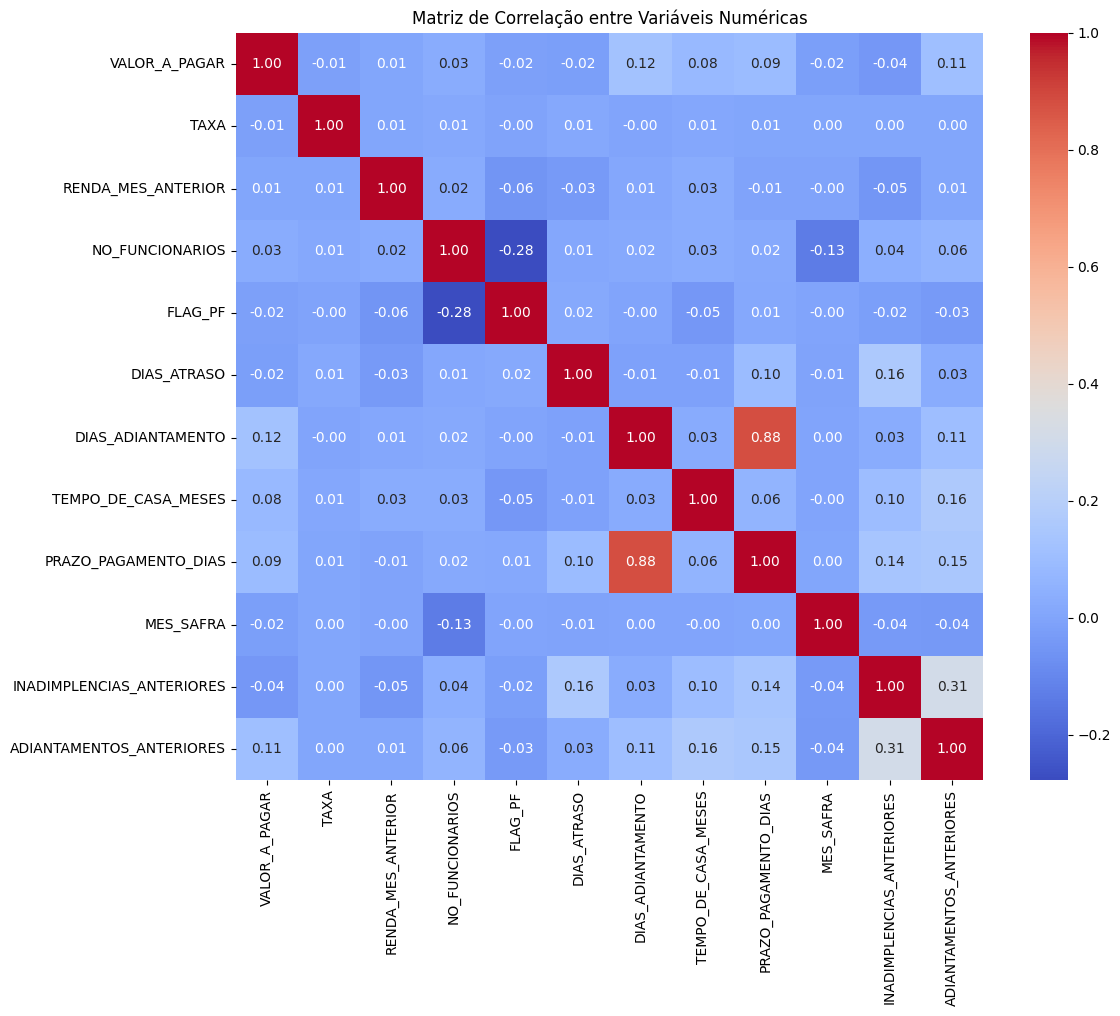

In [18]:
colunas_correlacao = [
    'VALOR_A_PAGAR',
    'TAXA',
    'RENDA_MES_ANTERIOR',
    'NO_FUNCIONARIOS',
    'FLAG_PF',
    'DIAS_ATRASO', # Não entrará no modelo para não ter data leackage e consequentemente overfitting
    #'TARGET_INADIMPLENCIA',
    'DIAS_ADIANTAMENTO', # Não entrará no modelo para não ter data leackage e consequentemente overfitting
    'TEMPO_DE_CASA_MESES',
    'PRAZO_PAGAMENTO_DIAS',
    'MES_SAFRA',
    'INADIMPLENCIAS_ANTERIORES',
    'ADIANTAMENTOS_ANTERIORES'
]

# Filtra apenas as colunas relevantes
df_numerico = merged_dataset[colunas_correlacao]

# Calcula a matriz de correlação de Pearson
matriz_correlacao = df_numerico.corr(method='pearson')

# Plot da matriz com Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacao, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

### Correlação com a variável target

Ao analisar a correlação entre as variáveis numéricas e o meu target **TARGET_INADIMPLENCIA**, percebo que **DIAS_ATRASO** é a variável com maior correlação positiva, o que era esperado, já que atrasos tendem a estar diretamente ligados à inadimplência. Em seguida, **INADIMPLENCIAS_ANTERIORES** também mostra uma correlação relevante, sugerindo que o histórico de inadimplência é um forte indicativo de recorrência. **PRAZO_PAGAMENTO_DIAS** aparece como outro fator associado positivamente, talvez indicando que prazos mais longos aumentem o risco. Por outro lado, variáveis como **VALOR_A_PAGAR** e **RENDA_MES_ANTERIOR** apresentam correlação negativa moderada, sugerindo que valores mais altos de pagamento ou renda estejam associados a um menor risco. Algumas variáveis como **TAXA** e **ADIANTAMENTOS_ANTERIORES** têm correlação praticamente nula, o que indica que não contribuem diretamente para a explicação da inadimplência.

/tmp/ipykernel_34723/1095478721.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='coolwarm')


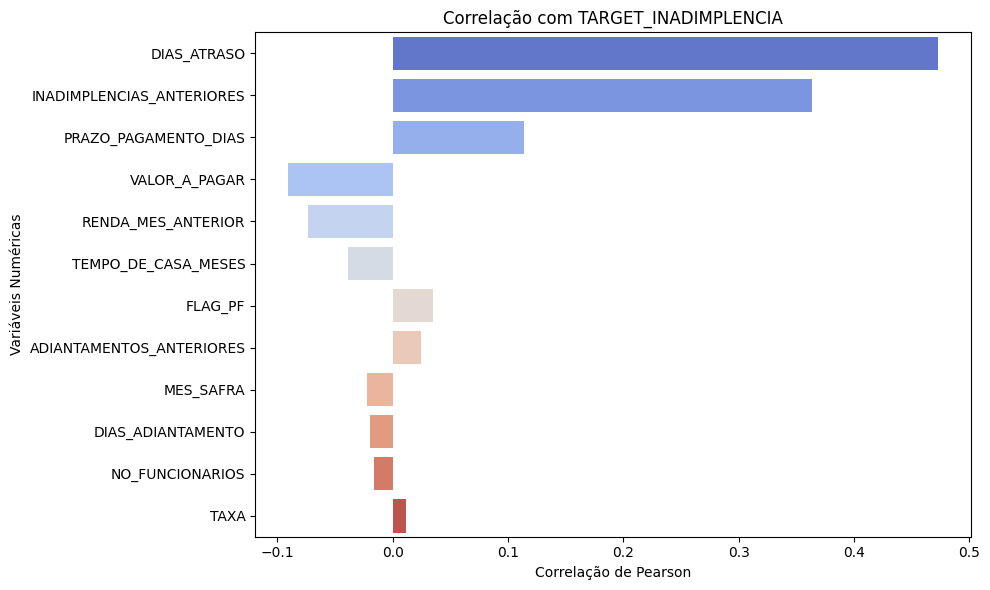

In [19]:
# Seleciona as colunas numéricas
numericas = merged_dataset.select_dtypes(include=['int64', 'float64', 'int32'])

numericas = numericas.drop(columns=['ID_CLIENTE'])
# Calcula correlação com a variável alvo
correlacoes = numericas.corr()['TARGET_INADIMPLENCIA'].drop('TARGET_INADIMPLENCIA')

# Ordena por correlação absoluta
correlacoes = correlacoes.reindex(correlacoes.abs().sort_values(ascending=False).index)

# Plota gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='coolwarm')
plt.title('Correlação com TARGET_INADIMPLENCIA')
plt.xlabel('Correlação de Pearson')
plt.ylabel('Variáveis Numéricas')
plt.tight_layout()
plt.show()


In [20]:
merged_dataset.to_csv('../data/processed/dataset_features_v1.csv', index=False)

## Deixando a base de teste similar a base de desenvolvimento 

Importando a base de teste já com todos os tratamentos realiados na análise exploratória de dados

In [21]:
merged_test = pd.read_csv('../data/processed/merged_test.csv')

Ajustando os tipos

In [22]:
# Conversão dos tipos numéricos e categóricos
merged_test = merged_test.astype({
    'ID_CLIENTE': 'int64',
    'VALOR_A_PAGAR': 'float64',
    'TAXA': 'float64',
    'RENDA_MES_ANTERIOR': 'float64',
    'NO_FUNCIONARIOS': 'int64',
    'FLAG_PF': 'int64', 
    #'DIAS_ATRASO': 'Int64',
    #'TARGET_INADIMPLENCIA': 'int64',
    'SEGMENTO_INDUSTRIAL': 'category',
    'PORTE': 'category',
    'CEP_2_DIG': 'category',
    #'DIAS_ADIANTAMENTO': 'int64',
    'DOMINIO_EMAIL': 'category',
})

# Conversão de datas
merged_test['SAFRA_REF'] = pd.to_datetime(
    merged_test['SAFRA_REF'], format='%Y-%m-%d', errors='coerce'
)

merged_test['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(
    merged_test['DATA_EMISSAO_DOCUMENTO'], format='%Y-%m-%d', errors='coerce'
)

# merged_dataset['DATA_PAGAMENTO'] = pd.to_datetime(
#     merged_dataset['DATA_PAGAMENTO'], format='%Y-%m-%d', errors='coerce'
# )

merged_test['DATA_VENCIMENTO'] = pd.to_datetime(
    merged_test['DATA_VENCIMENTO'], format='%Y-%m-%d', errors='coerce'
)

merged_test['DATA_CADASTRO'] = pd.to_datetime(
    merged_test['DATA_CADASTRO'], format='%Y-%m-%d', errors='coerce'
)

In [23]:
merged_test.dtypes

ID_CLIENTE                         int64
SAFRA_REF                 datetime64[ns]
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
RENDA_MES_ANTERIOR               float64
NO_FUNCIONARIOS                    int64
DATA_CADASTRO             datetime64[ns]
FLAG_PF                            int64
SEGMENTO_INDUSTRIAL             category
DOMINIO_EMAIL                   category
PORTE                           category
CEP_2_DIG                       category
dtype: object

Concatenando as duas bases de dados para criação de features de maneira mais consistente 

In [24]:
md = merged_dataset.copy() 
mt = merged_test.copy()


# flag indicando quis registros pertencem a qual base 
mt['EH_DEV'] = 0
md['EH_DEV'] = 1

# criando colunas que nao existe em teste
mt['DIAS_ATRASO'] = 0
mt['DIAS_ADIANTAMENTO'] = 0
mt['TARGET_INADIMPLENCIA'] = 0 # não existe inadimplencia nesta base ainda 

#concatenando ambas bases 
cc = pd.concat([md, mt], ignore_index=True)

Criando as mesmas features para a base de teste 

In [25]:
cc['TEMPO_CADASTRO_PARA_VENCIMENTO'] = (cc['DATA_VENCIMENTO'] - cc['DATA_CADASTRO']).dt.days

cc['TEMPO_DE_CASA_MESES'] = cc['TEMPO_CADASTRO_PARA_VENCIMENTO'] // 30

cc = cc.drop(columns='TEMPO_CADASTRO_PARA_VENCIMENTO')

cc['PRAZO_PAGAMENTO_DIAS'] = (cc['DATA_VENCIMENTO'] - cc['DATA_EMISSAO_DOCUMENTO']).dt.days

cc['MES_SAFRA'] = cc['SAFRA_REF'].dt.month

cc = cc.sort_values(by=['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO'])

cc['INADIMPLENCIAS_ANTERIORES'] = (
    cc
    .groupby('ID_CLIENTE')['TARGET_INADIMPLENCIA']
    .shift(fill_value=0)  # desloca a inadimplência para não pegar a atual (evita data leakage)
    .groupby(cc['ID_CLIENTE'])
    .cumsum()
)

# colocando um limite para essa abordagem para não prejudicar o modelo como um todo 
cc['INADIMPLENCIAS_ANTERIORES']=cc['INADIMPLENCIAS_ANTERIORES'].clip(upper=15)

# criação de coluna temporarea para armazenar os adiantamentos 
cc['HOUVE_ADIANTAMENTO'] = (cc['DIAS_ADIANTAMENTO'] >= 1).astype(int)

cc['ADIANTAMENTOS_ANTERIORES'] = (
    cc
    .groupby('ID_CLIENTE')['HOUVE_ADIANTAMENTO']
    .shift(fill_value=0)  # desloca a inadimplência para não pegar a atual (evita data leakage)
    .groupby(cc['ID_CLIENTE'])
    .cumsum()
)

cc['ADIANTAMENTOS_ANTERIORES']=cc['ADIANTAMENTOS_ANTERIORES'].clip(upper=15)

cc = cc.drop(columns='HOUVE_ADIANTAMENTO')

Conferindo se as novas features foram construídas corretamente na base de teste 

In [26]:
cc[cc['EH_DEV']==0]

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,CEP_2_DIG,DIAS_ATRASO,TARGET_INADIMPLENCIA,DIAS_ADIANTAMENTO,TEMPO_DE_CASA_MESES,PRAZO_PAGAMENTO_DIAS,MES_SAFRA,INADIMPLENCIAS_ANTERIORES,ADIANTAMENTOS_ANTERIORES,EH_DEV
73794,8784237149961904,2021-07-01,2021-07-02,NaT,2021-07-20,138986.90,5.99,384807.0,124,2011-02-14,...,27,0,0,0,126.0,18,7,1,5,0
73795,8784237149961904,2021-07-01,2021-07-15,NaT,2021-08-02,62641.90,5.99,384807.0,124,2011-02-14,...,27,0,0,0,127.0,18,7,1,5,0
73796,8784237149961904,2021-07-01,2021-07-27,NaT,2021-08-12,116033.85,8.99,384807.0,124,2011-02-14,...,27,0,0,0,127.0,16,7,1,5,0
73797,8784237149961904,2021-08-01,2021-08-01,NaT,2021-08-17,45597.80,8.99,103248.0,119,2011-02-14,...,27,0,0,0,127.0,16,8,1,5,0
73798,8784237149961904,2021-08-01,2021-08-05,NaT,2021-08-23,46317.75,8.99,103248.0,119,2011-02-14,...,27,0,0,0,128.0,18,8,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86053,9206030810342980458,2021-11-01,2021-11-05,NaT,2021-11-22,88179.95,11.99,856312.0,107,2005-08-08,...,91,0,0,0,198.0,17,11,2,12,0
86054,9206030810342980458,2021-11-01,2021-11-11,NaT,2021-11-29,27301.65,11.99,856312.0,107,2005-08-08,...,91,0,0,0,198.0,18,11,2,12,0
86055,9206030810342980458,2021-11-01,2021-11-14,NaT,2021-11-30,29051.65,11.99,856312.0,107,2005-08-08,...,91,0,0,0,198.0,16,11,2,12,0
86056,9206030810342980458,2021-11-01,2021-11-19,NaT,2021-12-06,110061.00,4.99,856312.0,107,2005-08-08,...,91,0,0,0,198.0,17,11,2,12,0


In [27]:
cc.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR',
       'NO_FUNCIONARIOS', 'DATA_CADASTRO', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'DIAS_ATRASO',
       'TARGET_INADIMPLENCIA', 'DIAS_ADIANTAMENTO', 'TEMPO_DE_CASA_MESES',
       'PRAZO_PAGAMENTO_DIAS', 'MES_SAFRA', 'INADIMPLENCIAS_ANTERIORES',
       'ADIANTAMENTOS_ANTERIORES', 'EH_DEV'],
      dtype='object')

In [28]:
cc.isnull().sum()

ID_CLIENTE                       0
SAFRA_REF                        0
DATA_EMISSAO_DOCUMENTO           0
DATA_PAGAMENTO               12264
DATA_VENCIMENTO                  0
VALOR_A_PAGAR                    0
TAXA                             0
RENDA_MES_ANTERIOR               0
NO_FUNCIONARIOS                  0
DATA_CADASTRO                   38
FLAG_PF                          0
SEGMENTO_INDUSTRIAL              0
DOMINIO_EMAIL                    0
PORTE                            0
CEP_2_DIG                        0
DIAS_ATRASO                      0
TARGET_INADIMPLENCIA             0
DIAS_ADIANTAMENTO                0
TEMPO_DE_CASA_MESES             38
PRAZO_PAGAMENTO_DIAS             0
MES_SAFRA                        0
INADIMPLENCIAS_ANTERIORES        0
ADIANTAMENTOS_ANTERIORES         0
EH_DEV                           0
dtype: int64

In [29]:
cc.dtypes

ID_CLIENTE                            int64
SAFRA_REF                    datetime64[ns]
DATA_EMISSAO_DOCUMENTO       datetime64[ns]
DATA_PAGAMENTO               datetime64[ns]
DATA_VENCIMENTO              datetime64[ns]
VALOR_A_PAGAR                       float64
TAXA                                float64
RENDA_MES_ANTERIOR                  float64
NO_FUNCIONARIOS                       int64
DATA_CADASTRO                datetime64[ns]
FLAG_PF                               int64
SEGMENTO_INDUSTRIAL                category
DOMINIO_EMAIL                      category
PORTE                              category
CEP_2_DIG                             int64
DIAS_ATRASO                           Int64
TARGET_INADIMPLENCIA                  int64
DIAS_ADIANTAMENTO                     int64
TEMPO_DE_CASA_MESES                 float64
PRAZO_PAGAMENTO_DIAS                  int64
MES_SAFRA                             int32
INADIMPLENCIAS_ANTERIORES             int64
ADIANTAMENTOS_ANTERIORES        

Tratando TEMPO_DE_CASA_MESES que será uma variável útil para a predição. Fazendo imputação por contexto

In [30]:
# Realiza a imputação hierárquica em uma coluna.
def imputacao_hierarquica(df, target_col, group_hierarchy, strategy='median'):
    
    imputed_col = df[target_col].copy()
    
    # Itera sobre a hierarquia de grupos
    for group in group_hierarchy:
        if strategy == 'mode':
            # Para moda, precisamos de um lambda para pegar o primeiro valor
            imputation_values = df.groupby(group)[target_col].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        else:
            imputation_values = df.groupby(group)[target_col].transform(strategy)
        
        imputed_col = imputed_col.fillna(imputation_values)
        
    # Aplica o fallback global final
    if strategy == 'median':
        global_fallback = df[target_col].median()
    else: # mode
        global_fallback = df[target_col].mode()[0]
        
    imputed_col = imputed_col.fillna(global_fallback)
    
    return imputed_col

hierarquia = [
    ['FLAG_PF', 'PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'CEP_2_DIG', 'TAXA'],
    ['PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'CEP_2_DIG', 'TAXA'],
    ['FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'CEP_2_DIG', 'TAXA'],
    ['FLAG_PF', 'PORTE', 'DOMINIO_EMAIL', 'CEP_2_DIG', 'TAXA'],
    ['FLAG_PF', 'PORTE', 'SEGMENTO_INDUSTRIAL', 'CEP_2_DIG', 'TAXA'],
    ['FLAG_PF', 'PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'TAXA'],
    ['FLAG_PF', 'PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'CEP_2_DIG'],
    ['FLAG_PF', 'PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL'],
    ['FLAG_PF', 'PORTE', 'SEGMENTO_INDUSTRIAL', 'TAXA'],
    ['FLAG_PF', 'PORTE', 'DOMINIO_EMAIL', 'CEP_2_DIG'],
    ['FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'TAXA'],
    ['PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'TAXA'],
    ['FLAG_PF', 'PORTE', 'SEGMENTO_INDUSTRIAL'],
    ['FLAG_PF', 'PORTE', 'TAXA'],
    ['FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'TAXA'],
    ['PORTE', 'SEGMENTO_INDUSTRIAL', 'TAXA'],
    ['FLAG_PF', 'DOMINIO_EMAIL', 'CEP_2_DIG'],
    ['FLAG_PF', 'PORTE'],
    ['FLAG_PF', 'TAXA'],
    ['FLAG_PF', 'SEGMENTO_INDUSTRIAL'],
    ['PORTE', 'TAXA'],
    ['SEGMENTO_INDUSTRIAL', 'TAXA'],
    ['DOMINIO_EMAIL', 'CEP_2_DIG'],
    ['FLAG_PF'],
    ['PORTE'],
    ['SEGMENTO_INDUSTRIAL'],
    ['DOMINIO_EMAIL'],
    ['CEP_2_DIG'],
    ['TAXA']
]


colunas_para_imputar = ['TEMPO_DE_CASA_MESES'] 
estrategias = {
    'TEMPO_DE_CASA_MESES': 'median',
}

# Aplica a imputação hierárquica (imputação com contexto) para cada coluna da lista
for coluna in colunas_para_imputar:
    
    hierar = hierarquia.copy()

    hierar = [
        [col for col in grupo if col != coluna]
        for grupo in hierarquia
        if any(col != coluna for col in grupo)  # garante que restou algo no grupo
    ]

    # Converte para float temporariamente, se for int
    is_int = pd.api.types.is_integer_dtype(cc[coluna])

    if is_int:
        cc[coluna] = cc[coluna].astype(float)

    print(f"Imputação hierárquica coluna: {coluna}, com estratégia: {estrategias.get(coluna)}")
    
    cc[coluna + '_INPUTED'] = imputacao_hierarquica(cc, coluna, hierar, strategy=estrategias.get(coluna))

    # Se originalmente era int, arredonda e converte de volta
    if is_int:
        cc[coluna] = cc[coluna + '_INPUTED'].round().astype('int64')
    else:
        cc[coluna] = cc[coluna + '_INPUTED']
    cc.drop(columns=[coluna + '_INPUTED'], inplace=True)


Imputação hierárquica coluna: TEMPO_DE_CASA_MESES, com estratégia: median


/tmp/ipykernel_34723/1531282718.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imputation_values = df.groupby(group)[target_col].transform(strategy)


In [31]:
cc.isnull().sum()

ID_CLIENTE                       0
SAFRA_REF                        0
DATA_EMISSAO_DOCUMENTO           0
DATA_PAGAMENTO               12264
DATA_VENCIMENTO                  0
VALOR_A_PAGAR                    0
TAXA                             0
RENDA_MES_ANTERIOR               0
NO_FUNCIONARIOS                  0
DATA_CADASTRO                   38
FLAG_PF                          0
SEGMENTO_INDUSTRIAL              0
DOMINIO_EMAIL                    0
PORTE                            0
CEP_2_DIG                        0
DIAS_ATRASO                      0
TARGET_INADIMPLENCIA             0
DIAS_ADIANTAMENTO                0
TEMPO_DE_CASA_MESES              0
PRAZO_PAGAMENTO_DIAS             0
MES_SAFRA                        0
INADIMPLENCIAS_ANTERIORES        0
ADIANTAMENTOS_ANTERIORES         0
EH_DEV                           0
dtype: int64

Separando base registros de teste dos outros registros 

In [32]:
test_features_v1 = cc[cc['EH_DEV']==0]

Retirando colunas desnecessárias

In [33]:
test_features_v1 = test_features_v1.drop(columns=['EH_DEV', 'DATA_PAGAMENTO', 'DIAS_ATRASO', 'TARGET_INADIMPLENCIA', 'DIAS_ADIANTAMENTO'])

Persistindo base tratada

In [34]:
test_features_v1.to_csv('../data/processed/test_features_v1.csv', index=False)